<a href="https://www.kaggle.com/code/suryateja35/30days-sales-forecast?scriptVersionId=212059240" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
 import pandas as pd

data= pd.read_csv('/kaggle/input/sales-transaction/Sales_transaction_gross_sales.csv')

In [2]:
data.head()

,TRANSACTION_DATE,ESTIMATED_GROSS_PROFIT_AMOUNT
0,2022-01-10,21.73
1,2022-02-07,25.72
2,2022-11-28,17.53
3,2022-02-21,25.69
4,2022-11-26,17.52


In [3]:
data.isnull().sum()

TRANSACTION_DATE                       0
ESTIMATED_GROSS_PROFIT_AMOUNT    2622104
dtype: int64

In [4]:
data.fillna({'ESTIMATED_GROSS_PROFIT_AMOUNT': 0}, inplace = True)
data.fillna({'ESTIMATED_GROSS_PROFIT_AMOUNT':data['ESTIMATED_GROSS_PROFIT_AMOUNT'].mean} , inplace = True)
data.isnull().sum()

TRANSACTION_DATE                 0
ESTIMATED_GROSS_PROFIT_AMOUNT    0
dtype: int64

In [5]:
new_data = data[data['ESTIMATED_GROSS_PROFIT_AMOUNT']>=0]
new_data.head()

,TRANSACTION_DATE,ESTIMATED_GROSS_PROFIT_AMOUNT
0,2022-01-10,21.73
1,2022-02-07,25.72
2,2022-11-28,17.53
3,2022-02-21,25.69
4,2022-11-26,17.52


In [6]:
new_data.to_csv('new_data.csv', index = False)
data = new_data

In [7]:
data['TRANSACTION_DATE'] = pd.to_datetime(data['TRANSACTION_DATE'])

In [8]:
daily_data = data.groupby('TRANSACTION_DATE')['ESTIMATED_GROSS_PROFIT_AMOUNT'].sum().reset_index()
print(daily_data)

     TRANSACTION_DATE  ESTIMATED_GROSS_PROFIT_AMOUNT
0          2020-01-02                       19759.60
1          2020-01-03                       17195.57
2          2020-01-05                       17485.47
3          2020-01-06                       22110.86
4          2020-01-07                       14211.80
...               ...                            ...
1649       2024-12-02                      767568.56
1650       2024-12-03                      534608.51
1651       2024-12-04                      530186.29
1652       2024-12-05                      532576.96
1653       2024-12-06                        1117.94

[1654 rows x 2 columns]


In [9]:
date_range = pd.date_range(
    start=daily_data['TRANSACTION_DATE'].min(), 
    end=daily_data['TRANSACTION_DATE'].max()
)
print(date_range)

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2024-11-27', '2024-11-28', '2024-11-29', '2024-11-30',
               '2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04',
               '2024-12-05', '2024-12-06'],
              dtype='datetime64[ns]', length=1801, freq='D')


12:56:10 - cmdstanpy - INFO - Chain [1] start processing
12:56:10 - cmdstanpy - INFO - Chain [1] done processing


forecast converted to CSV


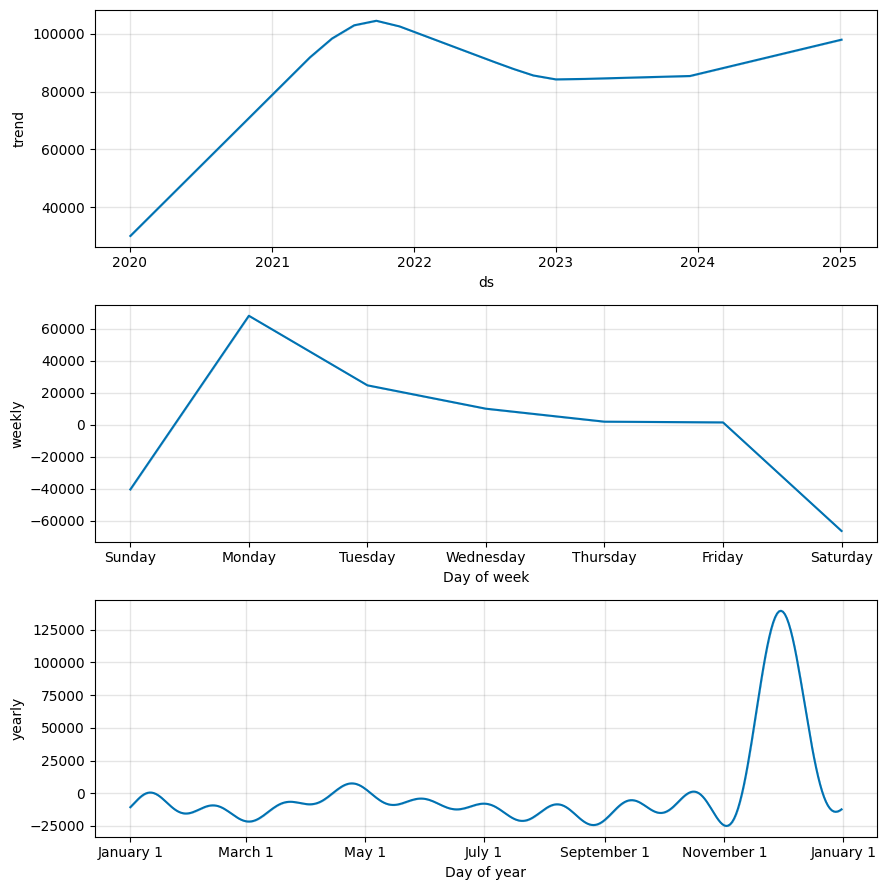

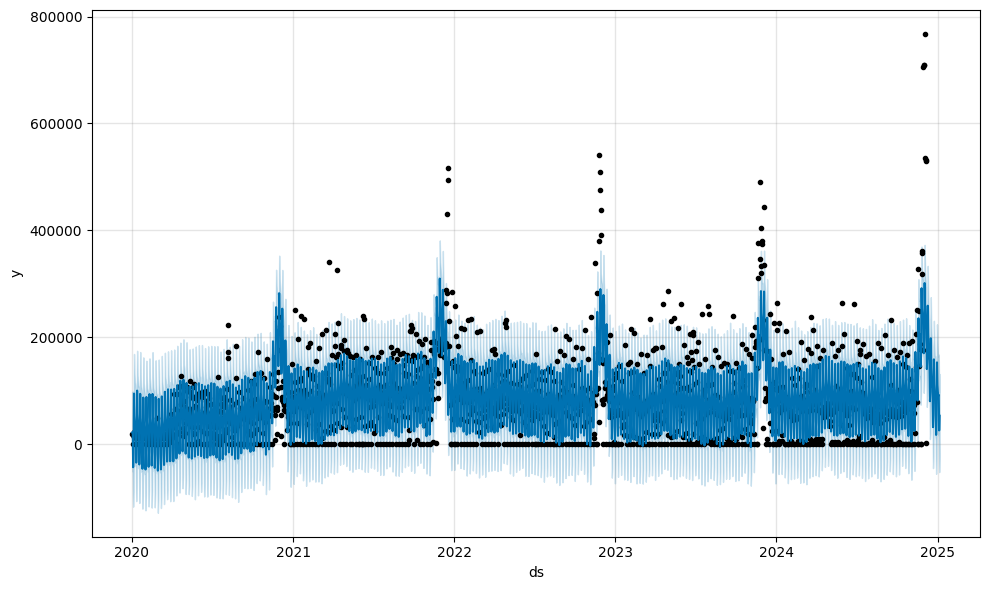

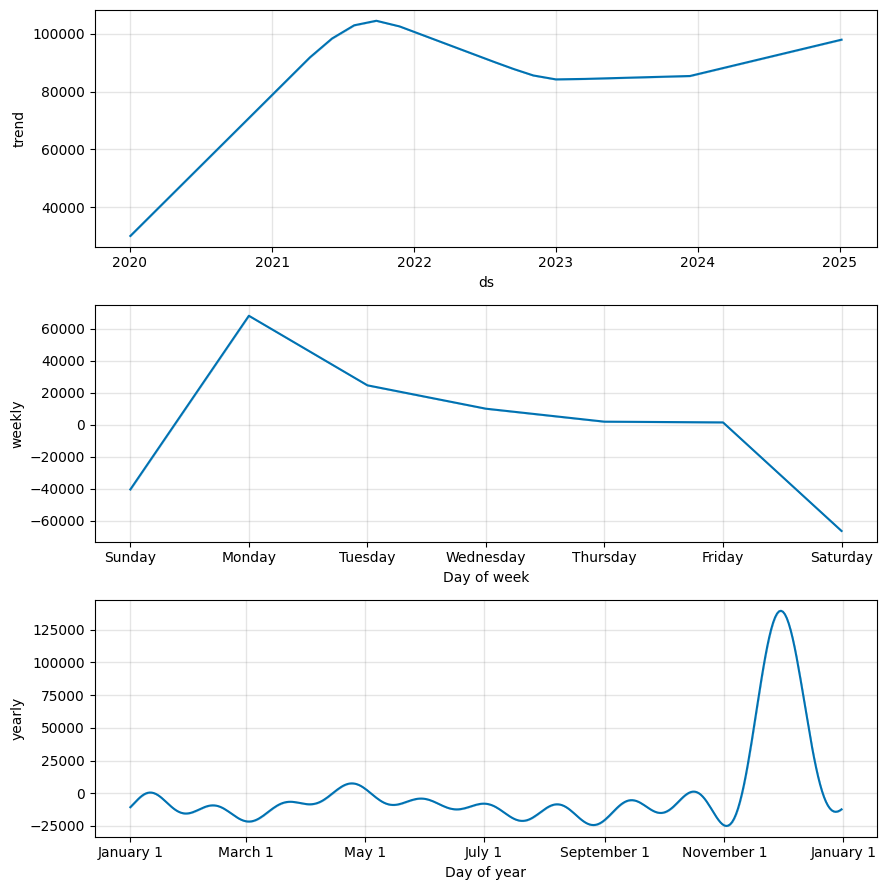

In [10]:
from prophet import Prophet
import matplotlib.pyplot as plt

prophet_data = daily_data.set_index('TRANSACTION_DATE').reindex(date_range, fill_value = 0).reset_index()
prophet_data.rename(columns={'index': 'ds', 'ESTIMATED_GROSS_PROFIT_AMOUNT': 'y'},inplace = True)

model = Prophet()
model.fit(prophet_data)

future = model.make_future_dataframe(periods = 30)
forecast = model.predict(future)

forecast.to_csv("/kaggle/working/sales_forecast_corrected.csv", index=False)
print("forecast converted to CSV")

model.plot(forecast)
model.plot_components(forecast)

In [11]:
forecast_data = pd.read_csv('/kaggle/working/sales_forecast_corrected.csv')
print(forecast_data)

              ds         trend     yhat_lower     yhat_upper   trend_lower  \
0     2020-01-02  29993.662564  -51119.497913   96582.554750  29993.662564   
1     2020-01-03  30127.630569  -52328.164887   98285.797204  30127.630569   
2     2020-01-04  30261.598574 -117033.086056   33289.978391  30261.598574   
3     2020-01-05  30395.566579  -88745.529099   63994.038835  30395.566579   
4     2020-01-06  30529.534584   17133.564991  168738.561468  30529.534584   
...          ...           ...            ...            ...           ...   
1826  2025-01-01  97874.157008   27336.827682  170220.907343  97835.818562   
1827  2025-01-02  97906.432005   16672.257973  163984.358093  97860.106111   
1828  2025-01-03  97938.707001   19955.081347  167310.385285  97885.900017   
1829  2025-01-04  97970.981998  -52451.095967   97750.045322  97912.346442   
1830  2025-01-05  98003.256994  -24003.622454  131086.204785  97935.579678   

       trend_upper  additive_terms  additive_terms_lower  \
0  

In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Actual values
actual = prophet_data['y']

# Predicted values (match the dates to actual data)
predicted = forecast.loc[:len(actual)-1, 'yhat']

In [13]:
adjusted_actual = np.where(actual == 0, 1e-10, actual)
mape = np.mean(np.abs((actual - predicted) / adjusted_actual)) * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Percentage Error (MAPE): 3285515208568656.5%


In [14]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 57585.4835852233
